In [1]:
import torch
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

import requests
import os

from celluloid import Camera
from IPython.display import HTML
from base64 import b64encode

import pandas as pd

In [2]:
import sys
sys.path.append('..')
from mix_NCA.NCA import NCA
from mix_NCA.utils_images import train_nca, standard_update_net
from mix_NCA.MixtureNCA import MixtureNCA
from mix_NCA.RobustnessAnalysis import RobustnessAnalysis


#reload modules if change jupyter kernel
%load_ext autoreload
%autoreload 2



metadataset = pd.read_csv("/home/salvatore.milite/data/automata_project/nd_NCA/data/microscope_data/BBBC031_v1_DatasetGroundTruth.csv", sep=";")

In [3]:
def load_microscopy_image(path, target_size=128, padding=0):
    """
    Load and preprocess emoji image to RGBA tensor with padding
    Args:
        path: path to image
        target_size: desired size of the image (without padding)
        padding: number of pixels to pad on each side
    Returns:
        Padded tensor of shape (1, 3, H+2*padding, W+2*padding)
    """
    img = Image.open(path).convert('RGBA')
    if target_size is not None:
        img = img.resize((target_size, target_size), Image.Resampling.LANCZOS)
    img_tensor = torch.from_numpy(np.array(img)) / 255.0
    
    # Convert to (1, 3, H, W) format
    img_tensor = img_tensor.permute(2, 0, 1).unsqueeze(0)
    
    # Add padding with zeros
    padded_tensor = torch.nn.functional.pad(
        img_tensor, 
        (padding, padding, padding, padding), 
        mode='constant', 
        value=0
    )
    
    return padded_tensor.float()

In [4]:
root = "/group/sottoriva/salvatore.milite/automata_project/nd_NCA/data/microscope_data/BBBC031_v1_dataset/Images"

In [5]:
img = load_microscopy_image(root + "/ProcessPlateSparse_wA03_s06_z1_t1_CELLMASK.png", target_size=256)

In [6]:
def plot_image(tensor):
    """
    Plot a tensor containing RGBA image data
    tensor shape should be (1, 3, H, W) or (3, H, W)
    """
    if len(tensor.shape) == 4:
        # If batch dimension exists, take first image
        tensor = tensor[0]
    
    # Convert tensor to numpy and ensure it's on CPU
    if torch.is_tensor(tensor):
        img = tensor.cpu().detach().numpy()
    else:
        img = tensor
    
    # Reshape to (H, W, 3)
    img = img.transpose(1, 2, 0)
    
    # Create figure with white background
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    #plt.show()

In [7]:
250 / 950

0.2631578947368421

In [8]:
metadataset

,ImageName,CellIdx,LocationX,LocationY,ColorParamsR,ColorParamsG,ColorParamsB,ShapeParams,ProcessID,PositionOnRegressionPlaneX,PositionOnRegressionPlaneY
0,ProcessPlateSparse_wA01_s01_z1_t1,1,784,420,0.607316,0.321287,0.713971,0.178493,4,0.678713,0.607316
1,ProcessPlateSparse_wA01_s01_z1_t1,2,522,812,0.265482,0.675522,0.589959,0.352510,4,0.324478,0.265482
2,ProcessPlateSparse_wA01_s01_z1_t1,3,208,511,0.885511,0.093673,0.208162,0.052040,4,0.906327,0.885511
3,ProcessPlateSparse_wA01_s01_z1_t1,4,11,566,0.481796,0.091448,0.609652,0.152413,5,0.908552,0.481796
4,ProcessPlateSparse_wA01_s01_z1_t1,5,243,742,0.485673,0.420813,0.935140,0.233785,4,0.579187,0.485673
...,...,...,...,...,...,...,...,...,...,...,...
8635,ProcessPlateSparse_wD06_s09_z1_t1,36,157,643,0.964977,0.006181,0.041204,0.010301,5,0.993819,0.964977
8636,ProcessPlateSparse_wD06_s09_z1_t1,37,241,221,0.919585,0.455683,0.536098,0.134024,2,0.544317,0.919585
8637,ProcessPlateSparse_wD06_s09_z1_t1,38,199,709,0.329081,0.118397,0.789317,0.197329,5,0.881603,0.329081
8638,ProcessPlateSparse_wD06_s09_z1_t1,39,186,117,0.882636,0.665065,0.782430,0.195607,2,0.334935,0.882636


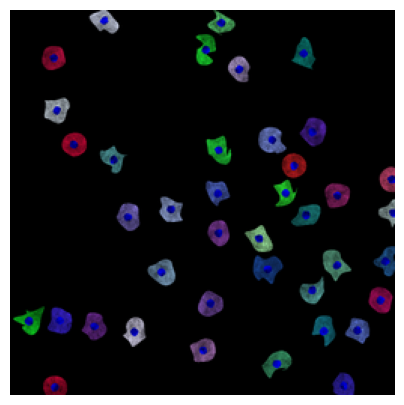

In [9]:

plot_image(img)



In [10]:
seed_1 = np.round(metadataset[metadataset["ImageName"] == "ProcessPlateSparse_wA03_s06_z1_t1"]["LocationX"].values * (250/950))
seed_2 = np.round(metadataset[metadataset["ImageName"] == "ProcessPlateSparse_wA03_s06_z1_t1"]["LocationY"].values * (250/950))
seed_1, seed_2

(array([ 81., 196., 212., 135.,  67., 167., 192., 241., 162.,  98., 149.,
        191., 125., 179.,  77., 127., 136.,  28., 135., 197.,  31.,  61.,
        213.,  29.,  32., 137., 184., 204., 173., 130., 226.,  55., 249.,
        244., 104.,  42., 170., 217., 248.,  12.]),
 array([209., 182., 166., 145.,  97., 169., 133., 188., 148., 170.,  38.,
         28., 221., 119., 134.,  26.,  91.,  31., 119.,  79.,  65.,   7.,
        121., 245., 202.,   8., 101., 208., 230., 191., 208., 206., 132.,
        163., 129.,  87.,  84., 244., 110., 202.]))

In [20]:
# Set up training parameters
DEVICE = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
TARGET_SIZE = 96
N_CHANNELS = 24  
BATCH_SIZE = 8
POOL_SIZE = 600 
PADDING = 0
NUM_STEPS = [30, 50]

seed_1 = np.round(metadataset[metadataset["ImageName"] == "ProcessPlateSparse_wA03_s06_z1_t1"]["LocationX"].values * (TARGET_SIZE/950))
seed_2 = np.round(metadataset[metadataset["ImageName"] == "ProcessPlateSparse_wA03_s06_z1_t1"]["LocationY"].values * (TARGET_SIZE/950))

SEED_LOC = (seed_1,seed_2)
GAMMA = 0.2
DECAY = 3e-5
DROPOUT = 0.2
HIDDEN_DIM = 128
TOTAL_STEPS = 8000
PRINT_EVERY = 200
SEED = 3
MILESTONES = [5000, 6000, 7000]
LEARNING_RATE = 1e-3
N_RULES = 5
SEED_VALUE = 1.0

# set pytorch, numpy and python seeds
torch.manual_seed(SEED)
np.random.seed(SEED)


In [21]:
target = load_microscopy_image(root + "/ProcessPlateSparse_wA03_s06_z1_t1_CELLMASK.png", target_size=TARGET_SIZE, padding=PADDING).to(DEVICE)

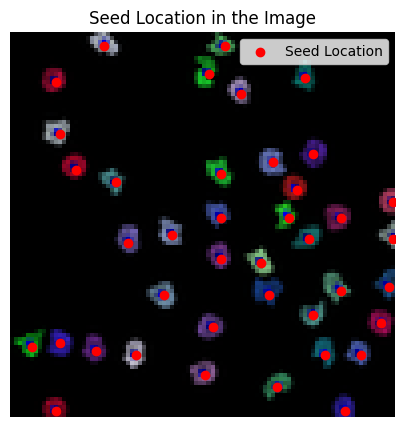

In [22]:
plot_image(target)

# plot seed location
plt.scatter(seed_1, seed_2, color='red', label='Seed Location')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Seed Location in the Image')
plt.legend()
plt.show()

In [23]:
model_mix = MixtureNCA(update_nets=standard_update_net, 
            state_dim=N_CHANNELS, 
            num_rules = N_RULES,
            hidden_dim=HIDDEN_DIM, 
            dropout=DROPOUT, 
            device=DEVICE, temperature=1, seed_value = SEED_VALUE)


In [24]:
loss_mix_nca = train_nca(model_mix, target, device=DEVICE, 
           num_steps=NUM_STEPS, 
           milestones=MILESTONES, 
           learning_rate=LEARNING_RATE, 
           gamma=GAMMA, 
           decay=DECAY, 
           total_steps=TOTAL_STEPS, 
           print_every=PRINT_EVERY, 
           batch_size = BATCH_SIZE, 
           state_dim = N_CHANNELS, 
           seed_loc = SEED_LOC, 
           pool_size = POOL_SIZE,
           temperature = 1,
           min_temperature = 1,
           anneal_rate = 0.01,
           straight_through = True,
           init_black = False
           )


step 0, dt 15.848s, loss 2.65e+03, log10(loss) 3.42
step 200, dt 133.269s, loss 1.02e-02, log10(loss) -1.99
step 400, dt 130.264s, loss 1.00e-02, log10(loss) -2.00
step 600, dt 132.034s, loss 9.68e-03, log10(loss) -2.01
step 800, dt 130.650s, loss 9.27e-03, log10(loss) -2.03
step 1000, dt 130.708s, loss 7.53e-03, log10(loss) -2.12
step 1200, dt 131.636s, loss 6.13e-03, log10(loss) -2.21
step 1400, dt 132.883s, loss 5.14e-03, log10(loss) -2.29
step 1600, dt 132.081s, loss 3.71e-03, log10(loss) -2.43
step 1800, dt 132.750s, loss 3.10e-03, log10(loss) -2.51
step 2000, dt 130.810s, loss 2.18e-03, log10(loss) -2.66
step 2200, dt 131.936s, loss 2.27e-03, log10(loss) -2.64
step 2400, dt 132.953s, loss 1.66e-03, log10(loss) -2.78
step 2600, dt 132.660s, loss 1.41e-03, log10(loss) -2.85
step 2800, dt 132.756s, loss 1.11e-03, log10(loss) -2.95
step 3000, dt 130.668s, loss 1.38e-03, log10(loss) -2.86
step 3200, dt 131.059s, loss 9.25e-04, log10(loss) -3.03
step 3400, dt 132.027s, loss 9.27e-04, l

In [25]:
torch.save(model_mix.state_dict(), "../models/model_mix_microscopy.pth")

In [26]:
def plot_img(img, fig=None, k=0, dpi=100):
  if fig is None:
    fig = plt.figure(dpi=dpi)
  if k > 0:
    img = img[k:-k,k:-k]
  plt.imshow(img) ; plt.axis('off')
  plt.tight_layout()
  return fig

def zoom(x, k=15):
  return x[...,k:-k,k:-k] if k>0 else x

def to_rgb(x):
  rgb, a = x[..., :3,:,:], x[..., 3:4,:,:].clip(0,1)
  return (1.0-a+rgb).clip(0,1)  # assume rgb premultiplied by alpha

def make_video(frames, path, interval=60, fig=None, **kwargs):
  if fig is None:
    fig = plt.figure(figsize=[3.25, 3.25], dpi=100)
  camera = Camera(fig)
  for i in range(len(frames)):
    fig = plot_img(frames[i], fig=fig, dpi=80)
    camera.snap()
  anim = camera.animate(blit=True, interval=interval, **kwargs)
  anim.save(path)
  plt.close()

In [27]:
# load the model state dict
model_mix.load_state_dict(torch.load("../models/model_mix_microscopy.pth"))


model_mix = model_mix.to(DEVICE)

/tmp/ipykernel_3138590/768046967.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_mix.load_state_dict(torch.load("../models/model_mix_microscopy.pth"))


In [207]:
# Construct a video of our CA's growth
init_state = torch.zeros(1, N_CHANNELS, *target.shape[-2:]).to(DEVICE)
init_state[...,3:, SEED_LOC[0], SEED_LOC[1]] = 1 # initially, there is just one cell

model_mix.eval()

frames = model_mix(init_state.to(DEVICE), 250, SEED_LOC, return_history=True, sample_non_differentiable=True, straight_through=True).cpu().detach().numpy()
frames = zoom(to_rgb(frames),k=0).squeeze(1)  # output has axes [time, rgb, width, height]
frames = frames.transpose(0,2,3,1)

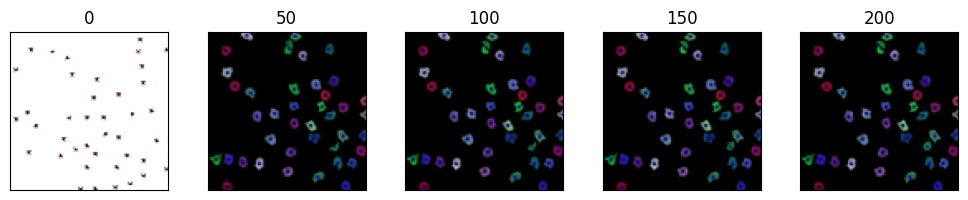

In [208]:
plot_every = 50
frames_ = frames[::plot_every]  

rows, cols = 1, 6
fig = plt.figure(figsize=[2*cols, 2*rows], dpi=100)
for i in range(rows):
  for j in range(cols):
    ix = 1 + i*cols + j
    if frames_.shape[0] >= ix:
      plt.subplot(rows,cols,ix)
      plt.xticks([],[]) ; plt.yticks([],[])
      plt.title(plot_every*(ix-1))
      plt.imshow(frames_[ix-1])

plt.tight_layout()
# save the image
plt.savefig(fname='../figures/microscopy_evolution_mix.png', bbox_inches='tight', dpi=300, format='png')

In [30]:
# Construct a video of our CA's growth
#init_state = torch.zeros(1, N_CHANNELS, *target.shape[-2:]).to(DEVICE)
init_state = target.to(DEVICE)
init_state[...,3:, SEED_LOC[0], SEED_LOC[1]] = 1 # initially, there is just one cell

#init_state_nca = mixture_model(init_state, 400, SEED_LOC, return_history=False).detach()
# fill extra channel dimension with zeros to match standard nca
init_state_nca = torch.cat([init_state, torch.zeros(1, N_CHANNELS - 4, *init_state.shape[-2:]).to(DEVICE)], dim=1)
init_state_nca.shape


torch.Size([1, 24, 96, 96])

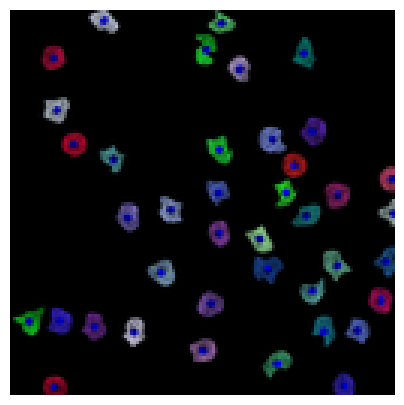

In [31]:
plot_image(load_microscopy_image(root + "/ProcessPlateSparse_wA03_s06_z1_t1_CELLMASK.png", padding=PADDING).to(DEVICE))

In [32]:
target = load_microscopy_image(root + "/ProcessPlateSparse_wA03_s06_z1_t1_CELLMASK.png", target_size=TARGET_SIZE, padding=PADDING).to(DEVICE)

# Construct a video of our CA's growth
#init_state = torch.zeros(1, N_CHANNELS, *target.shape[-2:]).to(DEVICE)
init_state = target.to(DEVICE)
init_state[...,3:, SEED_LOC[0], SEED_LOC[1]] = 1 # initially, there is just one cell

#init_state_nca = mixture_model(init_state, 400, SEED_LOC, return_history=False).detach()
# fill extra channel dimension with zeros to match standard nca
init_state_nca = torch.cat([init_state, torch.zeros(1, N_CHANNELS - 4, *init_state.shape[-2:]).to(DEVICE)], dim=1)
init_state_nca.shape

torch.Size([1, 24, 96, 96])

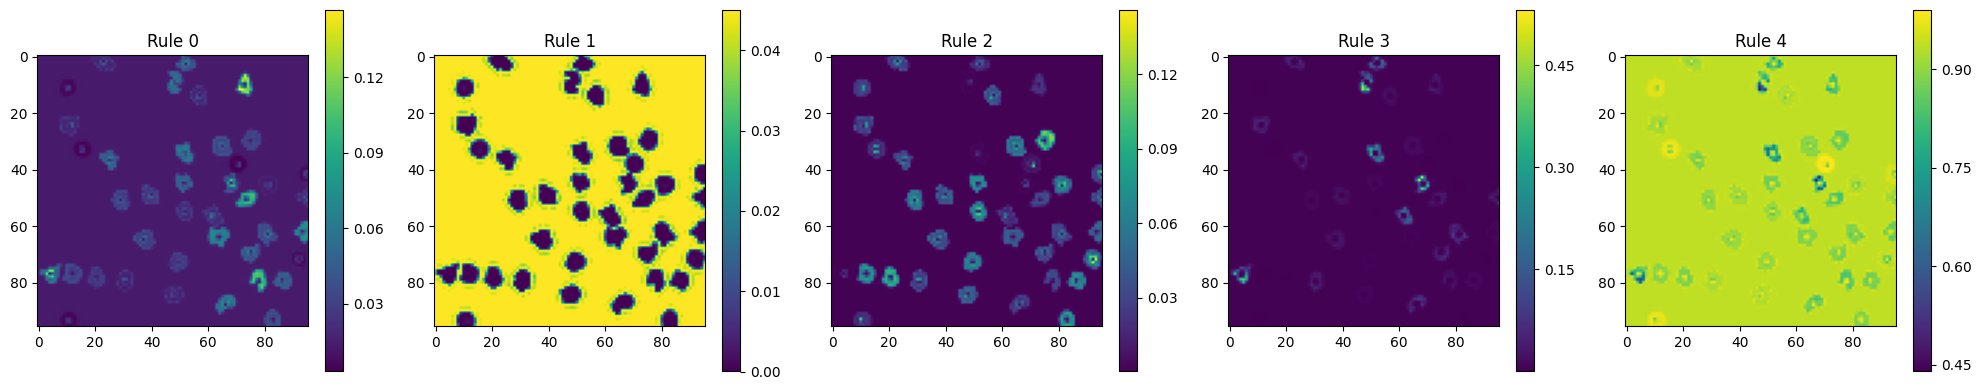

In [33]:
plot = model_mix.visualize_rule_assignments(init_state_nca)

# save the image
plot.savefig(fname='../figures/microscopy_evolution_rules.png', bbox_inches='tight', dpi=300, format='png')


40


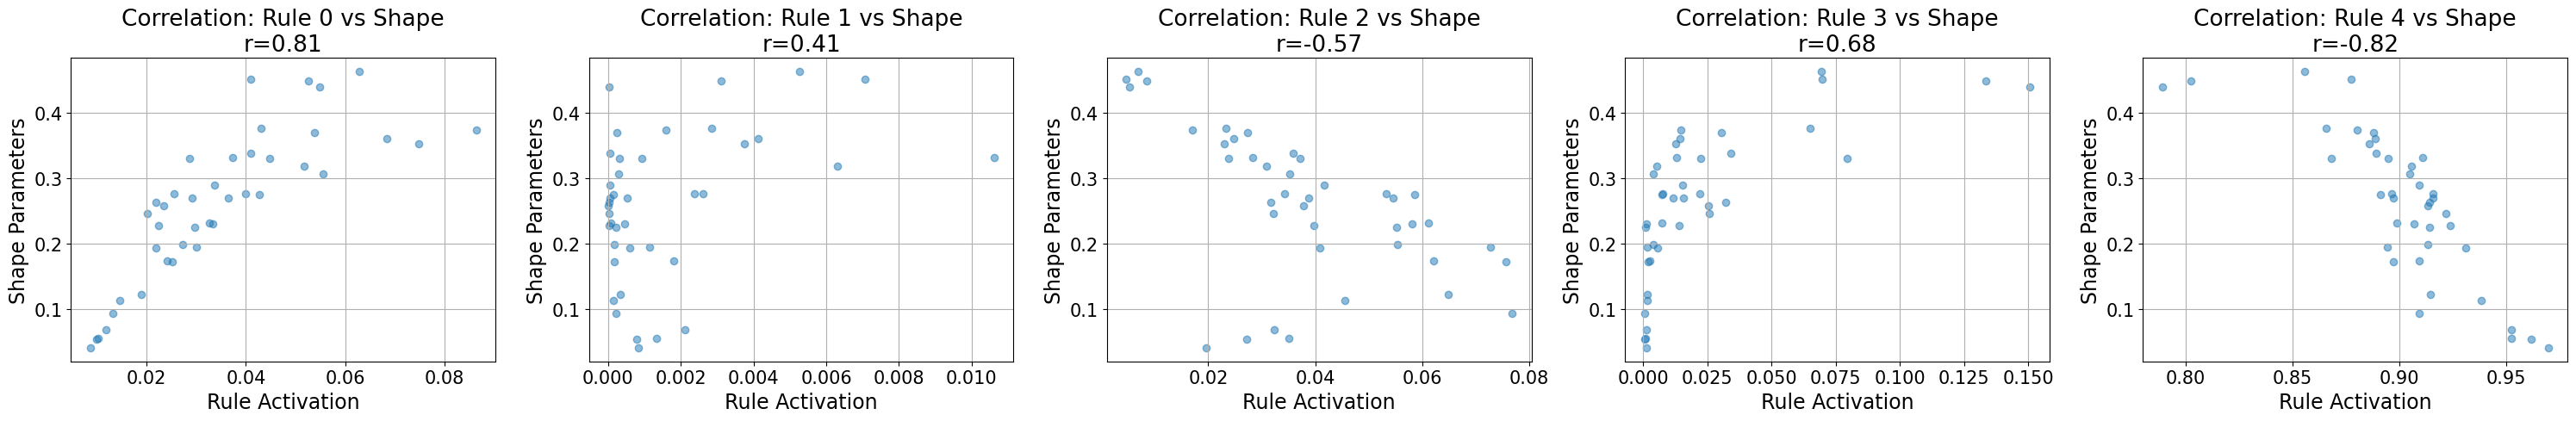

In [216]:
# Get rule probabilities from the model
rule_probs = model_mix.get_rule_probabilities(init_state_nca)  # Shape: [batch, rules, H, W]

metadataset_plot = metadataset[metadataset['ImageName'] == "ProcessPlateSparse_wA03_s06_z1_t1"]

# Extract cell centroids from metadata
centroids = metadataset_plot[['LocationX', 'LocationY']].values

# Calculate average rule activation around each centroid
window_size = 5   # Size of window around centroid to average
rule_activations = []

for x, y in centroids:
    x, y = int(x * (TARGET_SIZE/950)) , int(y * (TARGET_SIZE/950))
    # Get window around centroid, handling boundary conditions
    x_min = max(0, x - window_size//2)
    x_max = min(rule_probs.shape[-1], x + window_size//2)
    y_min = max(0, y - window_size//2) 
    y_max = min(rule_probs.shape[-2], y + window_size//2)
    
    # Calculate mean activation for each rule in window
    window_mean = rule_probs[0, :, y_min:y_max, x_min:x_max].mean((1,2))
    rule_activations.append(window_mean.detach().cpu().numpy())

rule_activations = np.array(rule_activations)  # Shape: [n_cells, n_rules]

print(len(centroids))

# Get shape parameters from metadata
shape_params = metadataset_plot['ShapeParams'].values

n_rules = rule_activations.shape[1]
fig, axes = plt.subplots(1, n_rules, figsize=(6 * n_rules, 5), sharey=False)

for rule_idx in range(n_rules):
    ax = axes[rule_idx] if n_rules > 1 else axes
    correlation = np.corrcoef(shape_params, rule_activations[:, rule_idx])[0, 1]
    ax.scatter(rule_activations[:, rule_idx], shape_params, alpha=0.5)
    ax.set_xlabel('Rule Activation', fontsize = 17)
    ax.set_ylabel(f'Shape Parameters', fontsize = 17)
    ax.set_title(f'Correlation: Rule {rule_idx} vs Shape\nr={correlation:.2f}', fontsize = 19)
    # increase fontsize of tick labels
    ax.tick_params(axis='both', labelsize=15)
    ax.grid(True)

plt.tight_layout()
#save the plot
plt.savefig(fname='../figures/rule_shape_correlation.png', bbox_inches='tight', dpi=500, format='png')
plt.show()

In [41]:
target = load_microscopy_image(root + "/ProcessPlateSparse_wA03_s06_z1_t1_CELLMASK.png", target_size=TARGET_SIZE, padding=PADDING).to(DEVICE)

# Construct a video of our CA's growth
#init_state = torch.zeros(1, N_CHANNELS, *target.shape[-2:]).to(DEVICE)
init_state = target.to(DEVICE)
init_state[...,3:, SEED_LOC[0], SEED_LOC[1]] = 1 # initially, there is just one cell

#init_state_nca = mixture_model(init_state, 400, SEED_LOC, return_history=False).detach()
# fill extra channel dimension with zeros to match standard nca
init_state_nca = torch.cat([init_state, torch.zeros(1, N_CHANNELS - 4, *init_state.shape[-2:]).to(DEVICE)], dim=1)
init_state_nca.shape

torch.Size([1, 24, 96, 96])

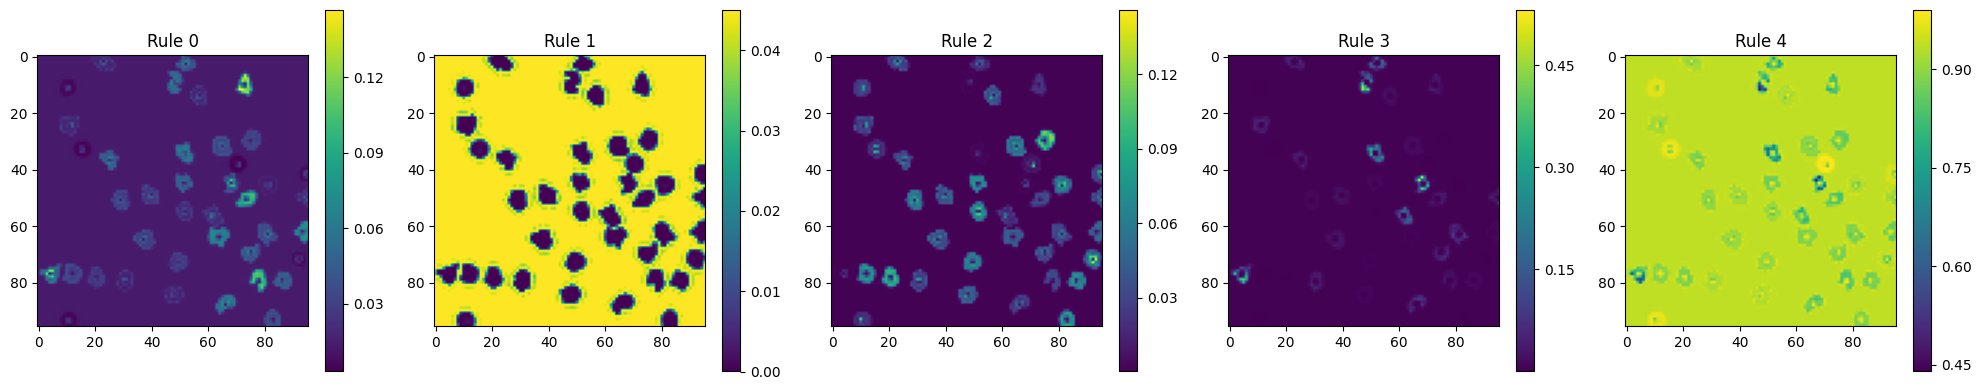

In [42]:
plot = model_mix.visualize_rule_assignments(init_state_nca)

# save the image
plot.savefig(fname='../figures/microscopy_evolution_rules_new_sample.png', bbox_inches='tight', dpi=300, format='png')


In [204]:
# Construct a video of our CA's growth
init_state = torch.zeros(1, N_CHANNELS, *target.shape[-2:]).to(DEVICE)
init_state[...,3:, SEED_LOC[0], SEED_LOC[1]] = 1 # initially, there is just one cell

model_mix.eval()
torch.manual_seed(9)
frames = model_mix(init_state.to(DEVICE), 850, SEED_LOC, return_history=True, sample_non_differentiable=True, straight_through=True, weights = torch.tensor([0.01,1,0.5,1,1]).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(DEVICE)).cpu().detach().numpy()
frames = zoom(to_rgb(frames),k=0).squeeze(1)  # output has axes [time, rgb, width, height]
frames = frames.transpose(0,2,3,1)

torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
t

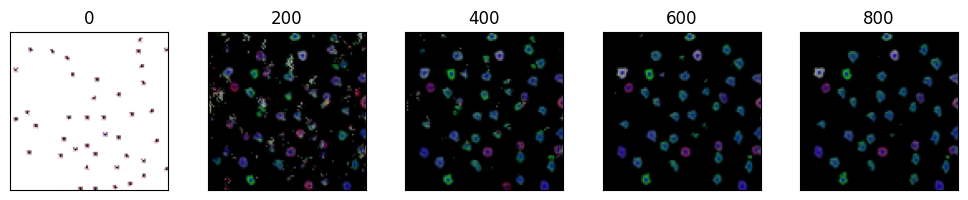

In [205]:
plot_every = 200
frames_ = frames[::plot_every]  

rows, cols = 1, 6
fig = plt.figure(figsize=[2*cols, 2*rows], dpi=100)
for i in range(rows):
  for j in range(cols):
    ix = 1 + i*cols + j
    if frames_.shape[0] >= ix:
      plt.subplot(rows,cols,ix)
      plt.xticks([],[]) ; plt.yticks([],[])
      plt.title(plot_every*(ix-1))
      plt.imshow(frames_[ix-1])

plt.tight_layout()
plt.savefig(fname='../figures/microscopy_evolution_perturb_1.png', bbox_inches='tight', dpi=300, format='png')

In [192]:
# Construct a video of our CA's growth
init_state = torch.zeros(1, N_CHANNELS, *target.shape[-2:]).to(DEVICE)
init_state[...,3:, SEED_LOC[0], SEED_LOC[1]] = 1 # initially, there is just one cell

model_mix.eval()
torch.manual_seed(12)
frames = model_mix(init_state.to(DEVICE), 810, SEED_LOC, return_history=True, sample_non_differentiable=True, straight_through=True, weights = torch.tensor([1,1,1,1,1.5]).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(DEVICE)).cpu().detach().numpy()
frames = zoom(to_rgb(frames),k=0).squeeze(1)  # output has axes [time, rgb, width, height]
frames = frames.transpose(0,2,3,1)

torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
torch.Size([1, 5, 96, 96])
t

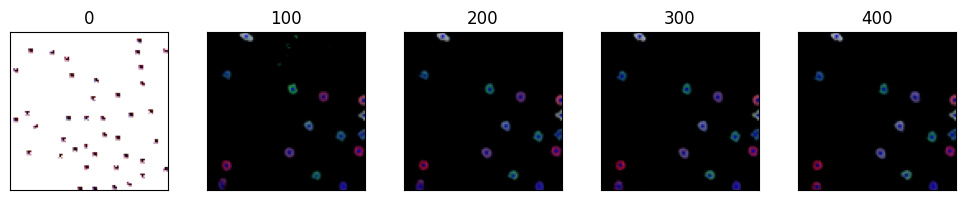

In [193]:
plot_every = 100
frames_ = frames[::plot_every]  

rows, cols = 1, 5
fig = plt.figure(figsize=[2*cols, 2*rows], dpi=100)
for i in range(rows):
  for j in range(cols):
    ix = 1 + i*cols + j
    if frames_.shape[0] >= ix:
      plt.subplot(rows,cols,ix)
      plt.xticks([],[]) ; plt.yticks([],[])
      plt.title(plot_every*(ix-1))
      plt.imshow(frames_[ix-1])

plt.tight_layout()
plt.savefig(fname='../figures/microscopy_evolution_perturb_2.png', bbox_inches='tight', dpi=300, format='png')